# Netflix Movie/Tv Show Trends

By, Wei Jiang

## Introduction

Netflix is one of the most popular steaming servies we have today and it is considered one of the top streaming companies in the United States. A big question is how does Netflix keep its user base interested and continue to do so. Is it making popular movies avlaible for users to stream? Is it releasing specific genres of movies and T.V. shows based on past trends?         

In this notebook, I will use a Netflix movie dataset to see if there is any kind of relationship between a country and  the numbers of movies/tv shows released in that country. Does is this trend consistent in each country and if so, is it a reflection of what Netflix wants to focus on, or are they releasing tv shows and movies at random?

## Tools Used

Tools used in the notebook are:
* Pandas
* Mathplotlib
* Numpy
* Netflix Tv Show and Movie Dataset from Kaggle

## Data Loading & Tidying

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

data = pd.read_csv("netflix_titles.csv")

# Drop columns that is not needed
data = data.drop(columns=["show_id", "director", "rating", "description"])

# convert the listed_in coulumn into a list so that it is easier to use
# convert release_year into an int
# convert countries into a list and np.nan if not listed
for index, row in data.iterrows():
    data.at[index, "listed_in"] = row["listed_in"].split(",")
    data.at[index, "release_year"] = int(row["release_year"])
    
    country = row["country"]
    if (type(country) == float):
        country = np.nan
    else:
        country = country.split(",")
    data.at[index, "country"] = country
# Drop all rows that NaN because not knowing the country isnt useful in the analysis
data.dropna()
data.head()

,type,title,cast,country,date_added,release_year,duration,listed_in
0,Movie,Norm of the North: King Sized Adventure,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...","[United States, India, South Korea, China]","September 9, 2019",2019,90 min,"[Children & Family Movies, Comedies]"
1,Movie,Jandino: Whatever it Takes,Jandino Asporaat,[United Kingdom],"September 9, 2016",2016,94 min,[Stand-Up Comedy]
2,TV Show,Transformers Prime,"Peter Cullen, Sumalee Montano, Frank Welker, J...",[United States],"September 8, 2018",2013,1 Season,[Kids' TV]
3,TV Show,Transformers: Robots in Disguise,"Will Friedle, Darren Criss, Constance Zimmer, ...",[United States],"September 8, 2018",2016,1 Season,[Kids' TV]
4,Movie,#realityhigh,"Nesta Cooper, Kate Walsh, John Michael Higgins...",[United States],"September 8, 2017",2017,99 min,[Comedies]


## What's in the Data Table?

The data shows information that is needed to analyze. The important fields are:
* Type - Moive or TV Show
* Country - Where the movie/tv show is listed
* Date_added
* Release_year
* listed_in - Genre

## Movie & T.v Show Quantity & More Data Tidying 

The first step is to find out which type of show is more popular on Nextflix and if this has changed across years.
The initial data goes back to 1964, but Netflix started streaming most of its contents in 2007. So the focus will be data from 2007 and onwards and not before Netflix began its streaming service.

In [182]:
# unique years in the data
years = data.release_year.unique()
# Filter the list so it only has data from 2007 to current year
years = list(filter(lambda year: 2007 <= year <= 2020, years))

# Keep only type and release year columns and group by year
groupByYear = data.groupby(["release_year"])
groupByYear = groupByYear[["type", "release_year"]]

# Go through each year and tally up the movies and tv shows type
movieMap = []
tvMap = []

for year in years:
    # Get the group of said year
    targetYear = groupByYear.get_group(year)
    
    # Local count for each year
    movieCount = 0
    tvCount = 0
    
    # Counting
    for index, row in targetYear.iterrows():
        if(str(row["type"]) == "Movie"):
            movieCount += 1
        else:
            tvCount += 1
    
    # Add it to the list
    movieMap.append([year, movieCount])
    tvMap.append([year, tvCount])

# Generate the table and merge them on year
movieDF = pd.DataFrame(movieMap, columns=["Year", "Movie Count"])
tvDF = pd.DataFrame(tvMap, columns=["Year", "TV Count"])

mergedDF = movieDF.merge(tvDF, how="left", left_on="Year", right_on="Year")
mergedDF.head()

,Year,Movie Count,TV Count
0,2019,400,443
1,2016,593,237
2,2013,177,60
3,2017,682,277
4,2014,213,75


#### Movie Count Across Year

Text(0, 0.5, 'Movie Count')

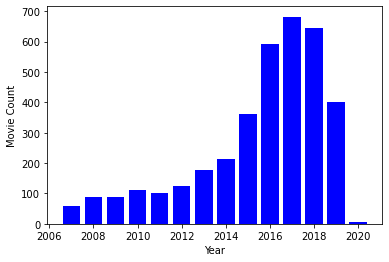

In [183]:
plt.bar(mergedDF["Year"], mergedDF["Movie Count"], color="b")
plt.xlabel("Year")
plt.ylabel("Movie Count")

#### T.V Show Count Across Year

Text(0, 0.5, 'TV Show Count')

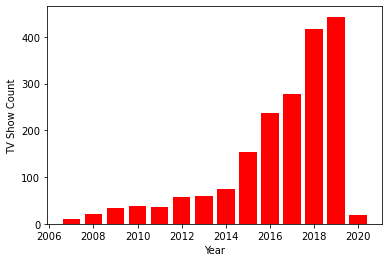

In [184]:
plt.bar(mergedDF["Year"], mergedDF["TV Count"], color="r")
plt.xlabel("Year")
plt.ylabel("TV Show Count")

#### Bar Merged

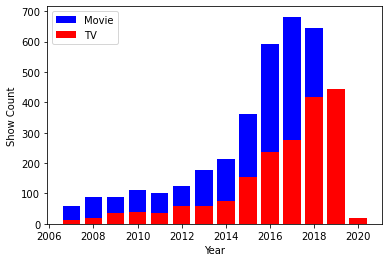

In [185]:
plt.bar(mergedDF["Year"], mergedDF["Movie Count"], color="b", label="Movie")
plt.bar(mergedDF["Year"], mergedDF["TV Count"], color="r", label="TV")
plt.xlabel("Year")
plt.ylabel("Show Count")
plt.legend(loc="upper left")

Across the years, there is always more movies being release on Netflix compared to T.V shows, except for 2019. In 2019, there were more TV shows release compared to movies.
According to William L. Hosch from Britannica, Netflix reached its biggest revenue generator in 2018. Perhaps Netlfix started making more of its original series, which tends to be in the TV show category.

## Standardization on Duration

Counting the number of movies and tv shows across years isnt very accurate because movies could have been more popular in the earlier years and they are much easier to produce because they are much shorter. Here, I will take the duration of each movie/tv show and standardize it.

Movies tend to last 90+ minutes and TV shows lasts 1 season. On average, TV shows will have about 13 episdoes per season and each episode lasts about 50 minutes. This brings an average TV show time to be about 650 minutes, which is about 7 movies.

### Find average movie duration in minutes and convert TV show's seasons into mins

In [186]:

# Method to extract the numbers from a string duration
def extractInt(string):
    nums = ""
    for i in range(len(string)):
        if string[i].isdigit():
            nums+= string[i]
    return int(nums)
      
# Go through each row and convert each duration into a int by minues
for index, row in data.iterrows():
    data.at[index, "release_year"] = int(row["release_year"])
    duration = row["duration"]
    
    # Movies have min and not seasons 
    if "min" in duration:
        duration = extractInt(duration)
    else:
        # Average TV show tends to be around 50 minutes and 13 epsidoes long
        duration = extractInt(duration)
        duration = duration * 13 * 50
    
    # Update the Dataframe
    data.at[index, "duration"] = duration

data.head()

,type,title,cast,country,date_added,release_year,duration,listed_in
0,Movie,Norm of the North: King Sized Adventure,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...","[United States, India, South Korea, China]","September 9, 2019",2019,90,"[Children & Family Movies, Comedies]"
1,Movie,Jandino: Whatever it Takes,Jandino Asporaat,[United Kingdom],"September 9, 2016",2016,94,[Stand-Up Comedy]
2,TV Show,Transformers Prime,"Peter Cullen, Sumalee Montano, Frank Welker, J...",[United States],"September 8, 2018",2013,650,[Kids' TV]
3,TV Show,Transformers: Robots in Disguise,"Will Friedle, Darren Criss, Constance Zimmer, ...",[United States],"September 8, 2018",2016,650,[Kids' TV]
4,Movie,#realityhigh,"Nesta Cooper, Kate Walsh, John Michael Higgins...",[United States],"September 8, 2017",2017,99,[Comedies]


### Recounting Movies and Weighted TV Shows

Using the same counting method as before, only this time, take the duration of the movie into account so that TV shows will get the same weight.
For example:
    1 Movie = 90 minutes = 1 count
    1 Season = 650 minutes = 7 count

In [187]:
# unique years in the data
years = data.release_year.unique()
# Filter the list so it only has data from 2007 to current year
years = list(filter(lambda year: 2007 <= year <= 2020, years))

# Average Movie time
avgMovieDuration = data.groupby(["type"]).get_group("Movie").duration.mean()
print(avgMovieDuration)

# Keep only type and release year columns and group by year
groupByYear = data.groupby(["release_year"])
groupByYear = groupByYear[["type", "release_year", "duration"]]

# Go through each year and tally up the movies and tv shows type
movieMap = []
tvMap = []

for year in years:
    # Get the group of said year
    targetYear = groupByYear.get_group(year)
    
    # Local count for each year
    movieCount = 0
    tvCount = 0
    
    # Counting
    for index, row in targetYear.iterrows():
        duration = row["duration"]
        if(str(row["type"]) == "Movie"):
            movieCount += math.ceil(duration/avgMovieDuration)
        else:
            tvCount += math.ceil(duration/avgMovieDuration)
    
    # Add it to the list
    movieMap.append([year, movieCount])
    tvMap.append([year, tvCount])

# Generate the table and merge them on year
movieDF = pd.DataFrame(movieMap, columns=["Year", "Movie Count"])
tvDF = pd.DataFrame(tvMap, columns=["Year", "TV Count"])

mergedDF = movieDF.merge(tvDF, how="left", left_on="Year", right_on="Year")
mergedDF.head()

99.10082063305978


,Year,Movie Count,TV Count
0,2019,542,5547
1,2016,821,2593
2,2013,263,717
3,2017,951,3574
4,2014,318,752


Text(0, 0.5, 'Movie Count')

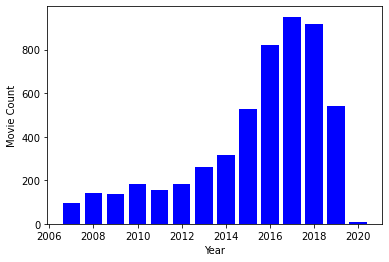

In [188]:
plt.bar(mergedDF["Year"], mergedDF["Movie Count"], color="b")
plt.xlabel("Year")
plt.ylabel("Movie Count")

Text(0, 0.5, 'TV Show Count')

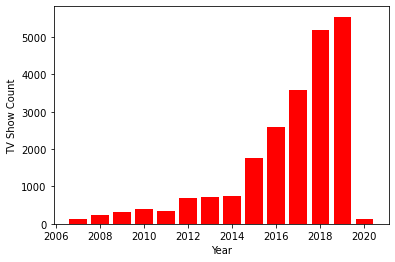

In [189]:
plt.bar(mergedDF["Year"], mergedDF["TV Count"], color="r")
plt.xlabel("Year")
plt.ylabel("TV Show Count")

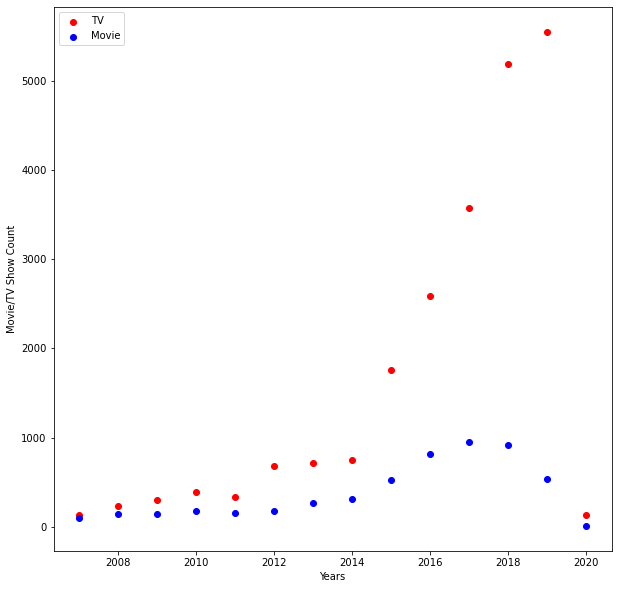

In [190]:
# Variables for Scatter Plit
year = mergedDF["Year"]
tvCount = mergedDF["TV Count"]
movieCount = mergedDF["Movie Count"]

plt.figure(figsize=(10,10))
plt.scatter(year,tvCount, c = 'r', label="TV")
plt.scatter(year,movieCount, c = 'b', label="Movie")
plt.xlabel("Years")
plt.ylabel("Movie/TV Show Count")
plt.legend(loc="upper left")

### After Transformation

After the transformation, it seems like there are actually more TV Shows than movies if we take into account the duration of the movies and TV Shows. 
From the graph, it looks like right after 2014, TV shows got more popular and continues that trend down the line and movies peaked at around 2017 and began to fall after.

This data shows that people prefer TV shows over movies across the years because TV Shows continues grow and movies begins to decline.

# Categorize by Country

Next, the data should be categorized by country because not all TV shows and movies are avliable in every country.
In this step, we will see if there is a coorelation between the number of movies and tv shows and country. Could Netflix release more movies or shows to certain countries because of demand? 

In this section, I will only look at:
* United States
* United Kingdom
* Hong Kong
* China
* France
* India
* South Korea
* Thailand
* Australia
* Canada

### Country List and Their Movie/TV Count w/ Linear Regresion Line

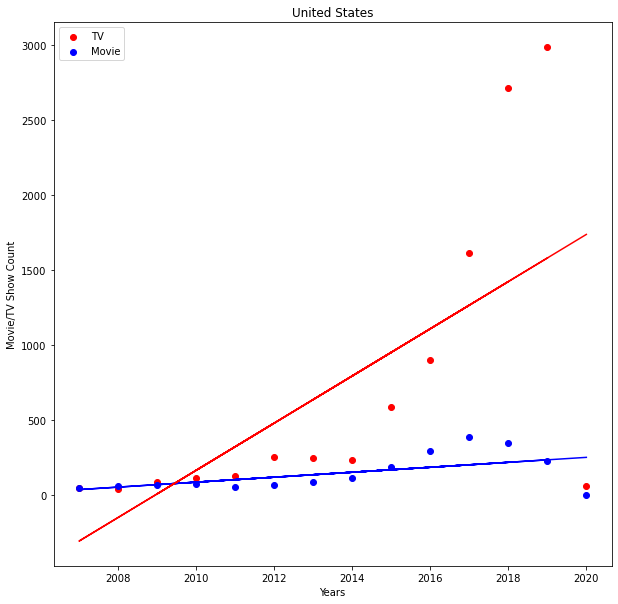

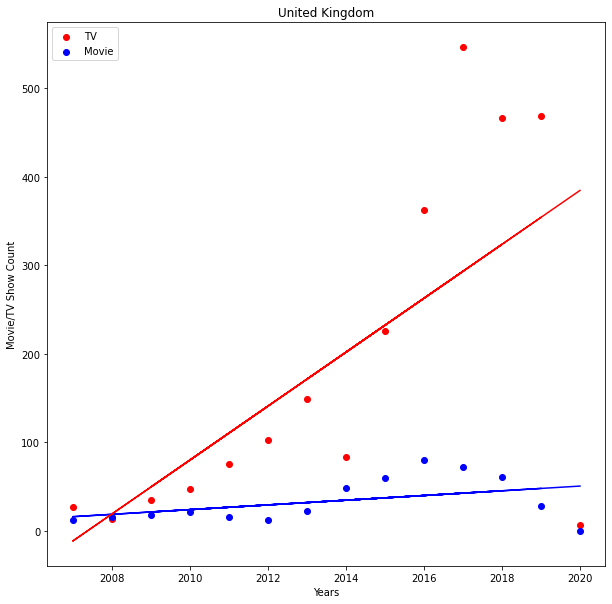

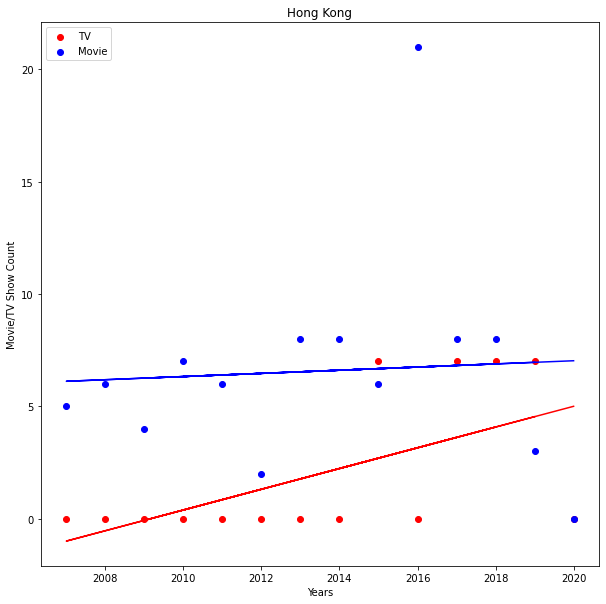

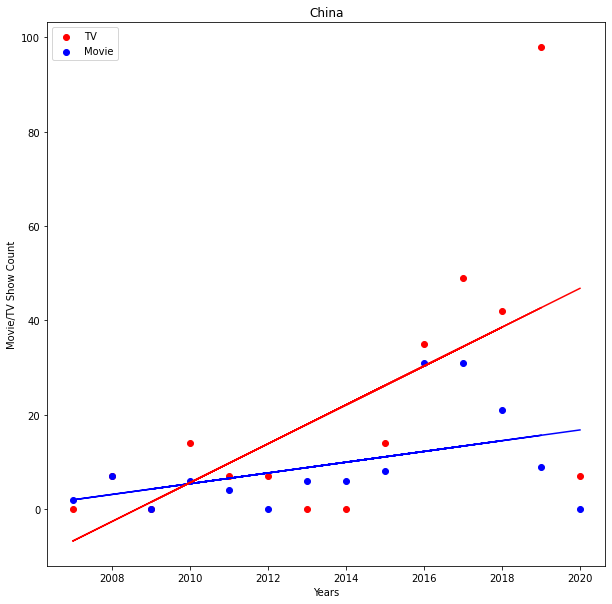

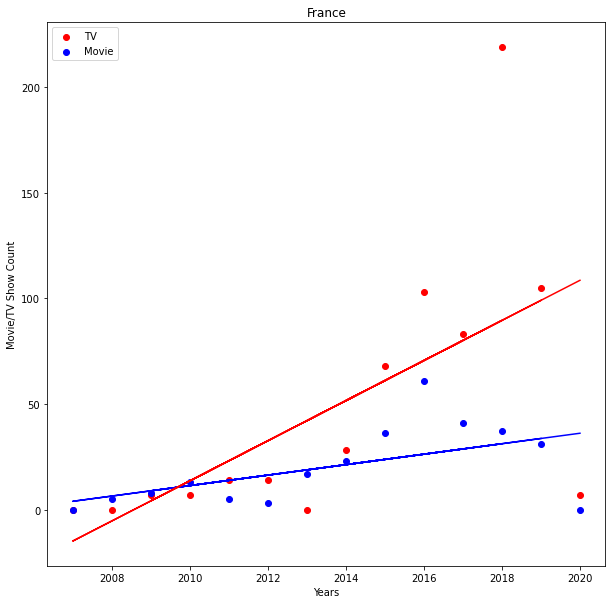

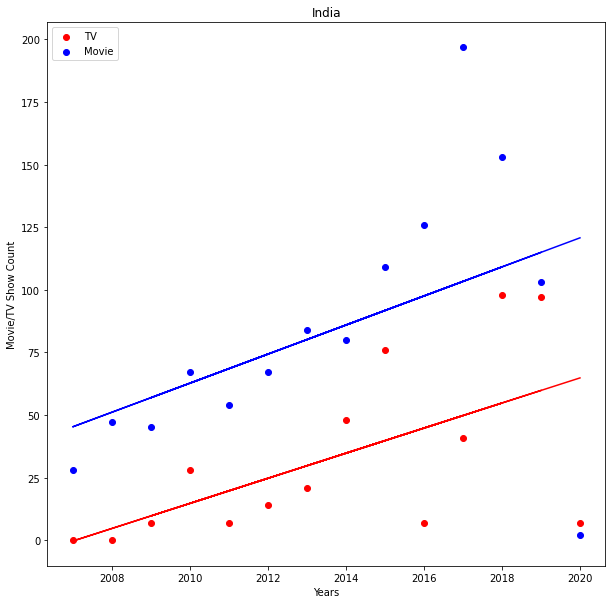

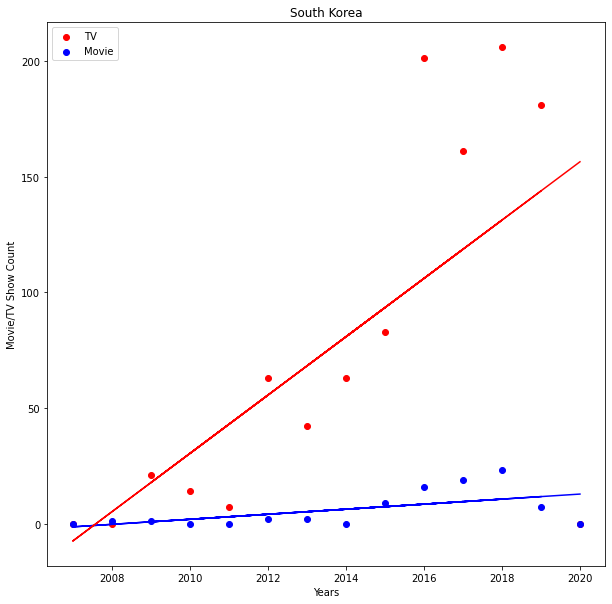

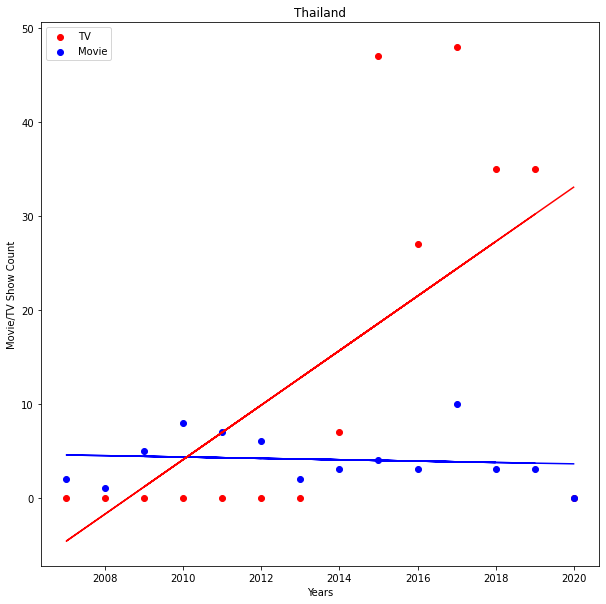

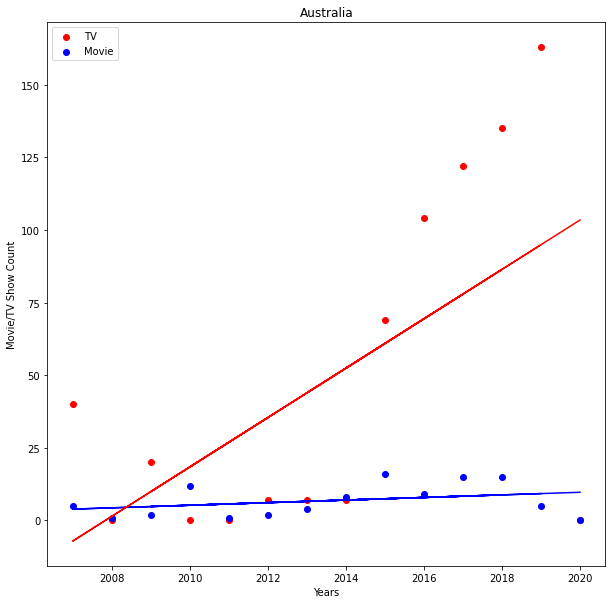

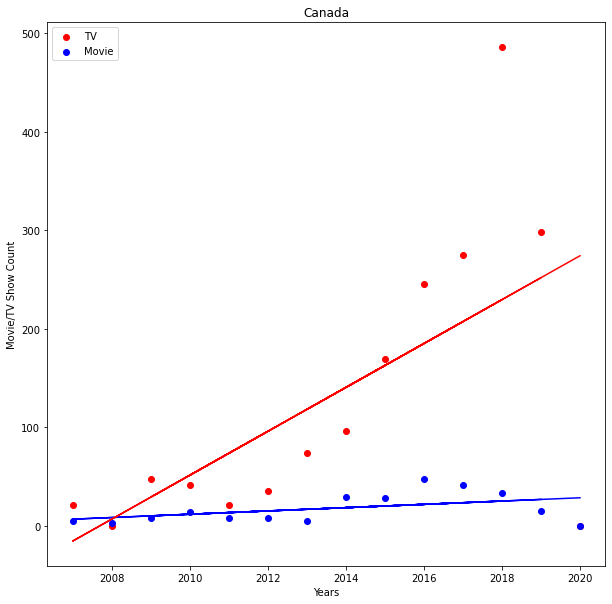

In [267]:
# Get a list of country names
countries = {
    "Movie Count" : {},
    "TV Count": {}
}

# Each data point in the data, add the country name
for index, row in data.iterrows():
    countryList = row["country"]
    if type(countryList) == float:
        continue
    for country in countryList:
        if country.strip() not in countries:
            countries["Movie Count"][country.strip()] = {} 
            countries["TV Count"][country.strip()] = {} 
            
            # Add years to each country for the respective year/tv count
            for year in years:
                countries["Movie Count"][country.strip()][year] = 0
                countries["TV Count"][country.strip()][year] = 0

                
# Go through each data item and add the count to the appropriate country
for index, row in data.iterrows():
    
    # Calculate the movie/Tv shows duration
    duration = row["duration"]
    category = row["type"]
    year = row["release_year"]
    count = math.ceil(duration/avgMovieDuration)
    countryList = row["country"]
    if type(countryList) == float:
        continue
        
    for country in countryList:
        country = country.strip()
        # Valid year in the years list that we defined earlier
        if (year in years):
            if category == "Movie":
                countries["Movie Count"][country][year] += count
            else:
                countries["TV Count"][country][year] += count

# Target Countries to look at the trends
targetCountries = [
    "United States",
    "United Kingdom",
    "Hong Kong",
    "China",
    "France",
    "India",
    "South Korea",
    "Thailand",
    "Australia",
    "Canada"
]
# Make a dataframe for each country that shows the numbers of movies and TV Shows for each
# Then plot it
for country in targetCountries:
    
    countryMovieDict = countries["Movie Count"][country]
    countryTVDict = countries["TV Count"][country]
    
    
    tvCount = []
    movieCount = []
    for year in years:
        tvCount.append(countryTVDict[year])
        movieCount.append(countryMovieDict[year])
    
    
    dataFrame = {
        "Year": years,
        "TV Count": tvCount,
        "Movie Count": movieCount
    }
    
    countryDF = pd.DataFrame(dataFrame)
    
    year = countryDF["Year"]
    tvCount = countryDF["TV Count"]
    movieCount = countryDF["Movie Count"]

    plt.figure(figsize=(10,10))
    plt.scatter(year,tvCount, c = 'r', label="TV")
    plt.scatter(year,movieCount, c = 'b', label="Movie")
    plt.xlabel("Years")
    plt.ylabel("Movie/TV Show Count")
    plt.title(country)
    plt.legend(loc="upper left")
    
    # Linear Regression Line
    
    # Movie
    m,b = np.polyfit(year, movieCount, 1)
    plt.plot(year, m*year+b, c="b")
    
    # TV Show
    m,b = np.polyfit(year, tvCount, 1)
    plt.plot(year, m*year+b, c="r")
    plt.show()
    

    
    
    

# Interpretation

From the scatter plot of 10 countries, we can clearly see that country does affect the frequency of movies and tv shows that Netflix releases. 
For example Netflix predominatly releases movies in India compared to any other country. For every other country that is not India, at one point, there is an intersection between the amount of movies and tv shows released at around 2008-2010.

From this, I can conlclude that Netflix is focusing on TV Shows rather than movies. From personal experince, Netflix Originals tend to have more TV shows than movies as well. This could also reflect the culture of the world because people may feel that a TV show provides more in-depth character development and plot because it can spand many seasons that can total up to 7 movies on average. Movies on the other hand, is limited to 90 minutes on average and it cannot explore a more detailed plot.

According to Dudley from Quora, he stated that TV Shows are often cheaper to make and is usually 2-10 times faster in production. This supports the idea that Netflix is leaning towards TV shows because it has a higher profit margin, or it is chaper to stream on their services.

# References

* Netflix Facts: https://www.britannica.com/topic/Netflix-Inc
* Why do TV shows generally have lower production costs than movies? : https://www.quora.com/Why-do-TV-shows-generally-have-lower-production-costs-than-movies
* Pandas Reference: https://pandas.pydata.org/docs/user_guide/index.html
* Mathplotlib Reference: https://realpython.com/python-matplotlib-guide/
* Kaggle Dataset: https://www.kaggle.com/shivamb/netflix-shows